# NLP Modelling

Using the NLP features engineered in the previous notebook, explore various models to determine whether the tweets contains a disaster. 

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

# NLP Preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLP Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Modelling - ML
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
xgboost.config_context(verbosity=0) # Silect XGBoost

# Deep Learning
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

# Monitoring progress
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

nltk.download('stopwords')

config = {
    'val_size': 0.2,
    'CV_splits': 5,
    'seed': 14,
    'n_cores': 16,
    'max_features': 2000,
    'refresh_embedding': False,
    'max_tweet_length': 128,
    'embedding_dim': 300,
    'num_epochs': 30,
    'batch_size': 32,
}

/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-03-26 10:47:29.261428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcachosoblechero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Load dataset and preprocessing

In [5]:
# Load dataset
input_path = "../input"
raw_tweets = pd.read_csv(os.path.join(input_path, "train.csv")).drop(['id'], axis=1)

# Use Twitter Tokenizer to tokenize tweets
tweet_tokenizer = TweetTokenizer()

# Tokenize raw tweets
raw_tweets['twitterTokens'] = raw_tweets.apply(lambda x: tweet_tokenizer.tokenize(x.text.lower()), axis=1)

# Remove stop words
english_stopwords = set(stopwords.words('english'))
raw_tweets['twitterTokens_noStop'] = raw_tweets.twitterTokens.apply(lambda x: [i for i in x if i not in english_stopwords])

# Perform stemming
ps = PorterStemmer()
raw_tweets['twitterTokens_Stem'] = raw_tweets.twitterTokens_noStop.apply(lambda x: [ps.stem(i) for i in x])

In [6]:
# Divide between features and labels
X = raw_tweets.drop(['target'], axis=1)
y = raw_tweets.target.values

In [4]:
# CountVectorizer can be used to perform this action in normal text
CountVec = CountVectorizer(stop_words='english', max_features=config['max_features'])
X_bow = CountVec.fit_transform(X.text)

# TfidfVectorizer can be used to perform this action in normal text
CountVecTFIDF = TfidfVectorizer(stop_words='english', max_features=config['max_features'])
X_tfidf = CountVecTFIDF.fit_transform(X.text)

In [5]:
# Generate Embeddings using Keras Interface
# Note this is different from what I did in Data Exploration

# Tokenize using Keras interface
keras_CountVect = Tokenizer()
keras_CountVect.fit_on_texts(X.text) 
X_keras_tokens = keras_CountVect.texts_to_sequences(X.text)
word_index = keras_CountVect.word_index # <- This is effectively a dictionary with all the required words, used later in the Embeddings
num_words = len(word_index)+1

# Pad the sequences
X_padded = pad_sequences(X_keras_tokens, maxlen=config['max_tweet_length'])
# Convert y to categorical
y_cat = to_categorical(y)

# Divide between train and validation, by shuffling the indices
indices = np.arange(X_padded.shape[0])
np.random.shuffle(indices)
X_padded = X_padded[indices]
y_cat = y_cat[indices]
num_validation_samples = int(config['val_size'] * X_padded.shape[0])
X_train_padded = X_padded[:num_validation_samples]
y_train_cat = y_cat[:num_validation_samples]
X_val_padded = X_padded[-num_validation_samples:]
y_val_cat = y_cat[-num_validation_samples:]

# Now we are ready to load the associated Embeddings
# Download or load from local
if config['refresh_embedding']:
    # Download Google's pre-trained Word2Vec model
    word2vec = api.load('word2vec-google-news-300')
    # Save the model for future reuse
    word2vec.save_word2vec_format('../Word2Vec/word2vec_300.kv')
else:
    word2vec = KeyedVectors.load_word2vec_format('../Word2Vec/word2vec_300.kv')


# Create embeddings by averaging the sentence
# embeddings = X.twitterTokens_noStop.apply(average_embedding, word_embeddings=word2vec, missing_random=False)
# X_embeddings = pd.DataFrame(embeddings.tolist())

In [6]:
# Associate each index with its embedding
# Create an embedding matrix as big as the words available
embedding_matrix = np.zeros((num_words, config['embedding_dim']))
# For each word in the dictionary, populate the embedding matrix
for word, idx in word_index.items():
    # If word is in embedding, store
    if word in word2vec:
        # Store the new embedding vector in the associated position
        # Otherwise, leave blank as zero
        embedding_matrix[idx] = word2vec[word]

In [ ]:
# Convert words into "BERT_interpretable" embeddings


# 1. Data Modeling

This section explores different architectures for text classification, ranging from Classic ML to RNN and CNN1D.

## Classic ML

In [37]:
def run_model_and_evaluate(model, X_train, y_train):
    
    # Instanciate a Cross-Validation model
    cv = StratifiedKFold(n_splits=config['CV_splits'])

    # Create empty results
    conf_matrix = np.zeros((2,2))
    accuracy = []
    recall = []
    auc = []

    # For every split    
    for idx_train, idx_test in tqdm(cv.split(X_train, y_train)):
    
        # Obtain the split indeces
        X_cv, y_cv = X_train[idx_train], y_train[idx_train]

        # Train the models 
        model.fit(X_cv, y_cv)

        # Obtain prediction dataset
        X_cv, y_cv = X_train[idx_test], y_train[idx_test]

        # Predict both models
        model_pred = model.predict(X_cv)

        # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
        conf_matrix += confusion_matrix(y_cv, model_pred)
        accuracy.append(accuracy_score(y_cv, model_pred))
        recall.append(recall_score(y_cv, model_pred))
        auc.append(roc_auc_score(y_cv, model_pred))

    return conf_matrix, accuracy, recall, auc

In [38]:
# Define the target models
dummy_model = DummyClassifier()
svc_model = SVC(kernel='rbf')
naive_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])
xg_model = XGBClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])

# Train all models
print(f"-> Training Dummy")
dummy_conf_matrix, dummy_acc, dummy_recall, dummy_auc = run_model_and_evaluate(dummy_model, X_bow, y)
print(f"-> Training SVC")
svc_conf_matrix, svc_acc, svc_recall, svc_auc = run_model_and_evaluate(svc_model, X_bow, y)
print(f"-> Training Multinomial NB")
naive_conf_matrix, naive_acc, naive_recall, naive_auc = run_model_and_evaluate(naive_model, X_bow, y)
print(f"-> Training Random Forest")
rf_conf_matrix, rf_acc, rf_recall, rf_auc = run_model_and_evaluate(rf_model, X_bow, y)
print(f"-> Training XGBoost")
xg_conf_matrix, xg_acc, xg_recall, xg_auc = run_model_and_evaluate(xg_model, X_bow, y)

-> Training Dummy


3it [00:00, 166.82it/s]


-> Training SVC


3it [00:07,  2.51s/it]


-> Training Multinomial NB


3it [00:00, 127.80it/s]


-> Training Random Forest


3it [00:00,  9.85it/s]


-> Training XGBoost


0it [00:00, ?it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [00:00,  3.94it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [00:00,  4.25it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [00:00,  3.98it/s]


## Deep Learning

In this section, we explore the different Deep Learning architectures available for NLP - from LSTM, CNN1D to Transformers

In [38]:
# Define the embeddings to use in this training
embedding_layer = Embedding(num_words,
                            config['embedding_dim'],
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=config['max_tweet_length'],
                            trainable=False)

# Define LSTM with non-trainable embeddings
LSTM1_model = Sequential()
LSTM1_model.add(embedding_layer)
LSTM1_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
LSTM1_model.add(Dense(1, activation='sigmoid'))
LSTM1_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy', 'Recall', 'AUC'])

LSTM1_model.fit(X_train_padded, y_train_cat,
        batch_size=32,
        epochs=config['num_epochs'],
        validation_data=(X_val_padded, y_val_cat),
        callbacks=[EarlyStopping(monitor="val_accuracy", patience=3)]
        )

Epoch 1/30
48/48 [==============================] - 15s 229ms/step - loss: 0.5665 - accuracy: 0.7116 - recall: 0.5142 - auc: 0.7594 - val_loss: 0.4748 - val_accuracy: 0.7786 - val_recall: 0.7121 - val_auc: 0.8459
Epoch 2/30
48/48 [==============================] - 11s 239ms/step - loss: 0.4471 - accuracy: 0.7996 - recall: 0.6835 - auc: 0.8598 - val_loss: 0.4563 - val_accuracy: 0.7898 - val_recall: 0.6432 - val_auc: 0.8521
Epoch 3/30
48/48 [==============================] - 11s 239ms/step - loss: 0.4005 - accuracy: 0.8259 - recall: 0.7057 - auc: 0.8853 - val_loss: 0.4753 - val_accuracy: 0.7898 - val_recall: 0.5952 - val_auc: 0.8526
Epoch 4/30
48/48 [==============================] - 12s 244ms/step - loss: 0.3796 - accuracy: 0.8417 - recall: 0.7215 - auc: 0.8972 - val_loss: 0.4787 - val_accuracy: 0.7786 - val_recall: 0.7301 - val_auc: 0.8509
Epoch 5/30
48/48 [==============================] - 11s 233ms/step - loss: 0.3605 - accuracy: 0.8449 - recall: 0.7405 - auc: 0.9087 - val_loss: 0.48

In [39]:
# Define the embeddings to use in this training - This time, trainable
embedding_layer = Embedding(num_words,
                            config['embedding_dim'],
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=config['max_tweet_length'],
                            trainable=True)

# Define LSTM with non-trainable embeddings
LSTM2_model = Sequential()
LSTM2_model.add(embedding_layer)
LSTM2_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
LSTM2_model.add(Dense(1, activation='sigmoid'))
LSTM2_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy', 'Recall', 'AUC'])

LSTM2_model.fit(X_train_padded, y_train_cat,
        batch_size=32,
        epochs=config['num_epochs'],
        validation_data=(X_val_padded, y_val_cat),
        callbacks=[EarlyStopping(monitor="val_accuracy", patience=3)]
        )

Epoch 1/30
48/48 [==============================] - 18s 301ms/step - loss: 0.5650 - accuracy: 0.7037 - recall: 0.4842 - auc: 0.7650 - val_loss: 0.4707 - val_accuracy: 0.7779 - val_recall: 0.7316 - val_auc: 0.8496
Epoch 2/30
48/48 [==============================] - 13s 278ms/step - loss: 0.3340 - accuracy: 0.8647 - recall: 0.7864 - auc: 0.9255 - val_loss: 0.4921 - val_accuracy: 0.7733 - val_recall: 0.7061 - val_auc: 0.8336
Epoch 3/30
48/48 [==============================] - 14s 284ms/step - loss: 0.1649 - accuracy: 0.9428 - recall: 0.9019 - auc: 0.9810 - val_loss: 0.5952 - val_accuracy: 0.7878 - val_recall: 0.6642 - val_auc: 0.8452
Epoch 4/30
48/48 [==============================] - 14s 287ms/step - loss: 0.0904 - accuracy: 0.9750 - recall: 0.9589 - auc: 0.9922 - val_loss: 0.8260 - val_accuracy: 0.6951 - val_recall: 0.8111 - val_auc: 0.8058
Epoch 5/30
48/48 [==============================] - 14s 286ms/step - loss: 0.0695 - accuracy: 0.9796 - recall: 0.9699 - auc: 0.9965 - val_loss: 0.77

## Pretrained BERT

In [ ]:
# Get inputs ready
X = raw_tweets.text.values
y = raw_tweets.target.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config['val_size'], random_state=config['seed'])

# Load the pre-trained BERT model
bert_model_name = "bert_en_uncased_L-12_H-768_A-12" # pre-trained BERT model name
bert_model_url = f"https://tfhub.dev/tensorflow/{bert_model_name}/4" # pre-trained BERT model URL
bert_model = hub.KerasLayer(bert_model_url, trainable=True)

# Load preprocessing steps
bert_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(bert_handle_preprocess)

# Create additional layers
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')
dropout_layer = tf.keras.layers.Dropout(0.1) # from tensorflow official tutorial

# Build layers 
bert_preprocess_out = bert_preprocess_model(input_layer)
bert_encoder_out = bert_model(bert_preprocess_out)
bert_encoder_out = bert_encoder_out['pooled_output']
bert_encoder_out = dropout_layer(bert_encoder_out) #Optional, to eliminate overfitting
classification_out = dense_layer(bert_encoder_out)
bert_model._name = "bert_encoder"

# Build model
tweets_classification_model = tf.keras.Model(input_layer, classification_out)
tweets_classification_model.get_layer('bert_encoder').trainable = True # Very important

# Compile model 
tweets_classification_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy', 'Recall', 'AUC'])
# Train model
tweets_classification_model.fit(X_train, y_train,
        batch_size=32,
        epochs=config['num_epochs'],
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor="val_accuracy", patience=3)]
        )


## Comparison

In [39]:
def plot_confusion_matrix(conf_matrix, title):
    
    plt.figure(figsize=(9,8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); 
    plt.ylabel('Actual'); 
    plt.title(title)
    plt.show()

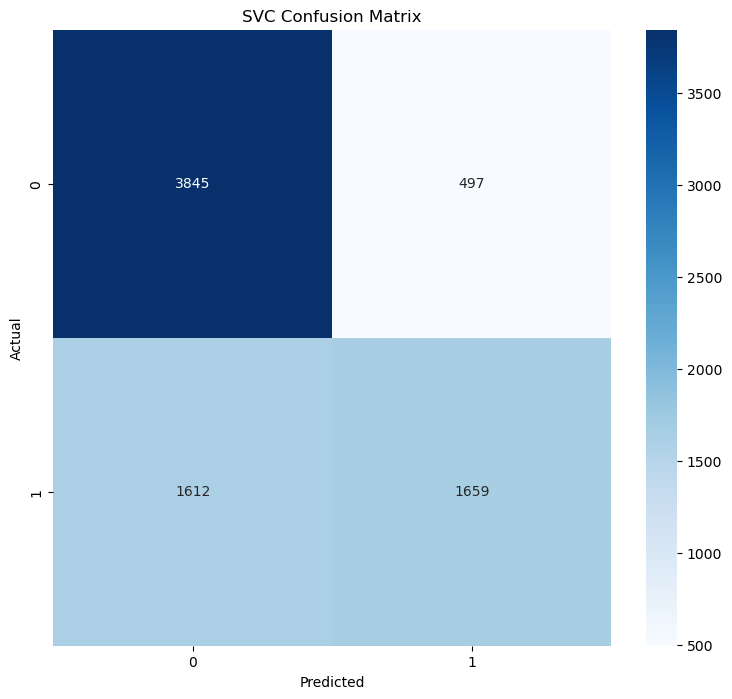

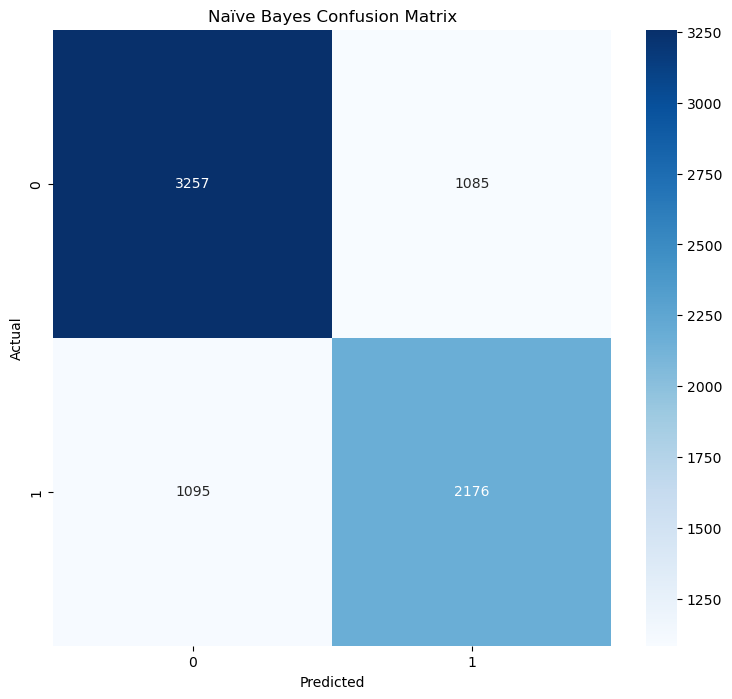

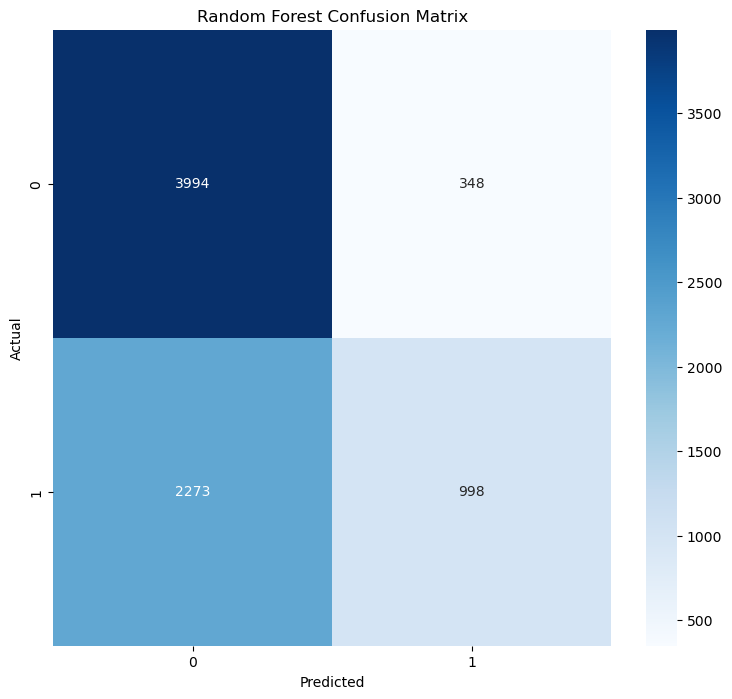

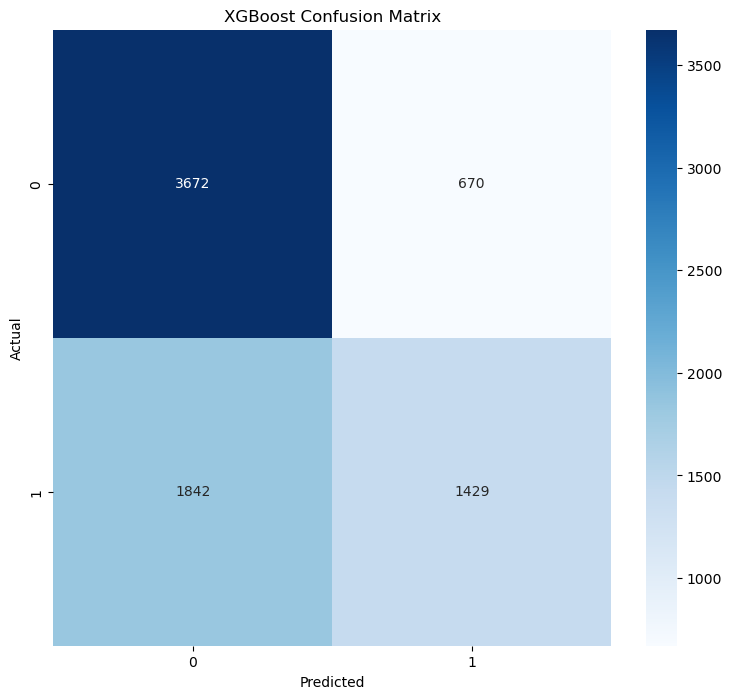

--------------
Accuracy Results
--------------
Null Hypothesis -> 0.5703402099673454
SVC             -> 0.7229783548116197
Naïve Bayes     -> 0.713650890384174
Random Forest   -> 0.6557249010934466
XGBoost         -> 0.6700441037654533
--------------

--------------
Recall Results
--------------
Null Hypothesis -> [0.0, 0.0, 0.0]
SVC             -> 0.5071950935791029
Naïve Bayes     -> 0.6652539403571619
Random Forest   -> 0.3051166480265279
XGBoost         -> 0.4368738384951101
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
SVC             -> 0.696368660836395
Naïve Bayes     -> 0.7076868673940048
Random Forest   -> 0.6124868482604203
XGBoost         -> 0.6412920103040497
--------------


In [40]:
# Analyse the results
# Accuracy
dummy_accuracy_av = sum(dummy_acc)/len(dummy_acc)
svc_accuracy_av = sum(svc_acc)/len(svc_acc)
rf_accuracy_av = sum(rf_acc)/len(rf_acc)
naive_accuracy_av = sum(naive_acc)/len(naive_acc)
xg_accuracy_av = sum(xg_acc)/len(xg_acc)
# Recall
dummy_recall_av = sum(dummy_recall)/len(dummy_recall)
svc_recall_av = sum(svc_recall)/len(svc_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
naive_recall_av = sum(naive_recall)/len(naive_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
dummy_auc_av = sum(dummy_auc)/len(dummy_auc)
svc_auc_av = sum(svc_auc)/len(svc_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
naive_auc_av = sum(naive_auc)/len(naive_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
plot_confusion_matrix(svc_conf_matrix, "SVC Confusion Matrix")
plot_confusion_matrix(naive_conf_matrix, "Naïve Bayes Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(xg_conf_matrix, "XGBoost Confusion Matrix")

print("--------------")
print("Accuracy Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_accuracy_av))
print("SVC             -> " + str(svc_accuracy_av))
print("Naïve Bayes     -> " + str(naive_accuracy_av))
print("Random Forest   -> " + str(rf_accuracy_av))
print("XGBoost         -> " + str(xg_accuracy_av))
print("--------------")
print("")
print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_recall))
print("SVC             -> " + str(svc_recall_av))
print("Naïve Bayes     -> " + str(naive_recall_av))
print("Random Forest   -> " + str(rf_recall_av))
print("XGBoost         -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_auc_av))
print("SVC             -> " + str(svc_auc_av))
print("Naïve Bayes     -> " + str(naive_auc_av))
print("Random Forest   -> " + str(rf_auc_av))
print("XGBoost         -> " + str(xg_auc_av))
print("--------------")